### **Imports**

In [3013]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [3014]:
import torch
import torch.nn as nn

In [3015]:
import importlib
import utils, models, training_utils
importlib.reload(utils)
importlib.reload(models)
importlib.reload(training_utils)

<module 'training_utils' from '/Users/pawelgrzeszczyk/Documents/02_studies/master/portfolio-optimization-dl/main/modeling/training_utils.py'>

### **Device**

In [3016]:
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")  # fallback to CPU if MPS isn't available

print(f"Using device: {device}")

Using device: mps


In [3017]:
# assets = ['eu50', 'n225', 'spx', 'us100']

# data = pd.DataFrame()

# for asset in assets:
#     stock_data = pd.read_csv(f'../data/data_files/{asset}.csv')[['Date', 'Price']]

#     stock_data.rename(columns={'Price': f'{asset.upper()}'}, inplace=True)
#     stock_data[f'{asset.upper()}'] = stock_data[f'{asset.upper()}'].str.replace(',', '').astype(float)

#     stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%m/%d/%Y')
#     stock_data = stock_data.set_index('Date')

#     if data.empty:
#         data = stock_data
#     else:
#         data = data.join(stock_data, how='outer')

# data = data.ffill()
# data = data.dropna()
# data

In [3018]:
# data, X_SEQ_LEN = utils.generate_data(end_date=datetime(2023, 1, 30),
#                                    days=1000,
#                                    num_ascending_start=2,
#                                    num_descending_start=2,
#                                    swap_count=50)
# # How many "next" days should be used to set the true label
# Y_SEQ_LEN = 1

# data

### **Reading the dataset**

In [3019]:
# Reading data, renaming columns and reordering
data = pd.read_csv('../data/data_files/w20_stock.csv').filter(regex='^Close_')
data.columns = [x.split('_')[1].split('.')[0] for x in data.columns]
data['Date'] = pd.read_csv('../data/data_files/w20_stock.csv')['Date']
data.insert(0, 'Date', data.pop('Date'))
data.head()

# Date as index
data = data.set_index('Date')

# Getting the first row with no NaN values
first_full_row = data.dropna().first_valid_index()
print(f'First row with no NaN values is from: ({first_full_row})')

# Removing rows with NaN values
data = data.loc[first_full_row:]
print(f'Number of rows with NaN values removed: {first_full_row}')
print(f'Number of rows with no NaN values: {data.shape[0]}')

# Take only sample of assets
data = data[data.columns[:4]]

data.head()

First row with no NaN values is from: (2021-05-27)
Number of rows with NaN values removed: 2021-05-27
Number of rows with no NaN values: 792


,ALE,ALR,BDX,CDR
Date,,,,
2021-05-27,58.279999,32.900002,313.5,175.500000
2021-05-28,58.500000,33.990002,306.0,178.580002
2021-05-31,57.660000,33.740002,298.5,168.740005
2021-06-01,59.209999,34.480000,299.0,153.380005
2021-06-02,59.180000,34.410000,295.0,161.580002


### **Prepare data for the model**

**Calculating percentage changes**

In [3020]:
# Calculate daily returns
data_returns = data.pct_change().dropna()
data_returns['SAVE'] = 0

ASSET_COUNT = data_returns.shape[1]

data_returns

,ALE,ALR,BDX,CDR,SAVE
Date,,,,,
2021-05-28,0.003775,0.033131,-0.023923,0.017550,0
2021-05-31,-0.014359,-0.007355,-0.024510,-0.055101,0
2021-06-01,0.026882,0.021932,0.001675,-0.091028,0
2021-06-02,-0.000507,-0.002030,-0.013378,0.053462,0
2021-06-04,-0.006928,0.009881,0.011864,0.059537,0
...,...,...,...,...,...
2024-07-15,-0.003397,0.000000,0.000000,0.033113,0
2024-07-16,-0.021677,-0.046960,-0.017531,-0.020147,0
2024-07-17,-0.030658,-0.023859,-0.022305,-0.004361,0


In [3021]:
data_model = data_returns.copy()

def calculate_rsi(data, window=15):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

for stock in data_model.columns:
    data_model[f'{stock}_MA_15'] = data_model[stock].rolling(window=15).mean()  # 15-day moving average
    data_model[f'{stock}_STD_15'] = data_model[stock].rolling(window=15).std()  # 15-day moving std dev
    data_model[f'{stock}_CUM_RET'] = (1 + data_model[stock]).cumprod() - 1     # Cumulative returns
    data_model[f'{stock}_RSI'] = calculate_rsi(data_model[stock])              # RSI

data_model = data_model.drop(columns='SAVE_RSI')
data_model = data_model.dropna()

print(f'Data shape: {data_model.shape}')
data_model.head()

Data shape: (777, 24)


,ALE,ALR,BDX,CDR,SAVE,ALE_MA_15,ALE_STD_15,ALE_CUM_RET,ALE_RSI,ALR_MA_15,...,BDX_STD_15,BDX_CUM_RET,BDX_RSI,CDR_MA_15,CDR_STD_15,CDR_CUM_RET,CDR_RSI,SAVE_MA_15,SAVE_STD_15,SAVE_CUM_RET
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-18,0.016246,-0.022571,-0.012259,0.015801,0,0.002069,0.012468,0.030371,52.688215,0.002832,...,0.014646,-0.100478,52.352969,0.004225,0.048693,0.047635,49.894492,0.0,0.0,0
2021-06-21,-0.010824,-0.009062,0.000000,-0.002611,0,0.001096,0.012888,0.019218,47.182025,0.000019,...,0.013950,-0.100478,54.598512,0.002881,0.048577,0.044900,48.810093,0.0,0.0,0
2021-06-22,-0.019360,0.020944,0.010638,-0.030538,0,0.000762,0.013372,-0.000515,48.997486,0.001906,...,0.013443,-0.090909,56.504728,0.004519,0.046867,0.012991,51.530591,0.0,0.0,0
2021-06-23,0.034335,0.043051,-0.007018,0.001237,0,0.001259,0.014502,0.033802,51.422919,0.003314,...,0.013414,-0.097289,48.338856,0.010670,0.038789,0.014245,55.779054,0.0,0.0,0
2021-06-24,0.038008,0.016898,0.021201,0.011461,0,0.003827,0.017306,0.073095,58.085320,0.004576,...,0.014534,-0.078150,56.291488,0.007870,0.036952,0.025869,46.837275,0.0,0.0,0


**Convert to target shape**

In [3022]:
X_SEQ_LEN = 10
Y_SEQ_LEN = 5

In [3023]:
import numpy as np
import torch

X_train, X_test, Y_train, Y_test = utils.create_sequences(data_returns = data_model, 
                                                          X_seq_len = X_SEQ_LEN, 
                                                          Y_seq_len = Y_SEQ_LEN, 
                                                          test_size=0.3,
                                                          device=device)

In [3024]:
print(f'X shape: \n\t{X_train.shape}')
print(f'X sample: \n\t{X_train[0]}')

X shape: 
	torch.Size([534, 10, 24])
X sample: 
	tensor([[ 1.6246e-02, -2.2571e-02, -1.2259e-02,  1.5801e-02,  0.0000e+00,
          2.0689e-03,  1.2468e-02,  3.0371e-02,  5.2688e+01,  2.8322e-03,
          2.2071e-02,  3.9818e-02,  4.3070e+01, -6.9334e-03,  1.4646e-02,
         -1.0048e-01,  5.2353e+01,  4.2253e-03,  4.8693e-02,  4.7635e-02,
          4.9894e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.0824e-02, -9.0616e-03,  0.0000e+00, -2.6107e-03,  0.0000e+00,
          1.0956e-03,  1.2888e-02,  1.9218e-02,  4.7182e+01,  1.9407e-05,
          2.0571e-02,  3.0395e-02,  4.4922e+01, -5.3385e-03,  1.3950e-02,
         -1.0048e-01,  5.4599e+01,  2.8812e-03,  4.8577e-02,  4.4900e-02,
          4.8810e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.9360e-02,  2.0944e-02,  1.0638e-02, -3.0538e-02,  0.0000e+00,
          7.6222e-04,  1.3372e-02, -5.1474e-04,  4.8997e+01,  1.9060e-03,
          2.1137e-02,  5.1976e-02,  5.3494e+01, -2.9953e-03,  1.3443e-02,
         -9.0

In [3025]:
print(f'Y shape: \n\t{Y_train.shape}')
print(f'Y sample: \n\t{Y_train[0]}')

Y shape: 
	torch.Size([534, 5, 24])
Y sample: 
	tensor([[ 5.6463e-03,  6.4158e-03, -5.4446e-03,  7.6287e-03,  0.0000e+00,
          1.0138e-02,  1.7560e-02,  1.6129e-01,  5.1203e+01,  2.3570e-03,
          2.9029e-02,  4.8936e-02,  5.2447e+01, -2.6803e-03,  1.1042e-02,
         -1.2600e-01,  4.9951e+01,  1.9808e-03,  2.9929e-02,  8.3761e-02,
          4.4708e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.0242e-02, -1.9994e-02, -1.8248e-03,  8.9379e-03,  0.0000e+00,
          1.1259e-02,  1.7638e-02,  1.8480e-01,  5.2666e+01,  6.4603e-04,
          2.9571e-02,  2.7963e-02,  4.7309e+01, -3.5025e-03,  1.0432e-02,
         -1.2759e-01,  4.7100e+01,  2.2251e-03,  2.9972e-02,  9.3447e-02,
          5.0361e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.2455e-02, -2.6907e-02, -2.0110e-02, -2.3867e-02,  0.0000e+00,
          1.1759e-02,  1.7553e-02,  1.9955e-01,  5.1166e+01,  8.8981e-04,
          2.9309e-02,  3.0390e-04,  5.0409e+01, -4.8432e-03,  1.1213e-02,
         -1.45

**True labels**

| Function                  | Arguments      | Description                                                                  |
|---------------------------|----------------|------------------------------------------------------------------------------|
| `get_Y_max_one`            | `Y`            | Pick one asset with the highest returns                                       |
| `get_Y_max_light`          | `Y`            | Distribute weights among assets with positive returns depending on the returns value |
| `get_Y_sharpe_one`         | `X, Y`         | Pick one asset with the highest Sharpe ratio                                  |
| `get_Y_sharpe_light`       | `X, Y`         | Distribute weights among assets with positive returns depending on the Sharpe ratio value |

In [3026]:
# Y_train_true_labels = utils.get_Y_sharpe_light(X_train, Y_train).to(device)
# Y_test_true_labels = utils.get_Y_sharpe_light(X_test, Y_test).to(device)
Y_train_true_labels = utils.get_Y_max_light(Y_train[:, :, :ASSET_COUNT]).to(device)
Y_test_true_labels = utils.get_Y_max_light(Y_test[:, :, :ASSET_COUNT]).to(device)

print(f'Y_true_labels shape: \n\t{Y_true_labels.shape}')
print(f'Y_true_labels sample: \n\t{Y_true_labels[0]}')

Y_true_labels shape: 
	torch.Size([72, 5])
Y_true_labels sample: 
	tensor([0.8247, 0.1753, 0.0000, 0.0000, 0.0000])


### **Model**

In [3027]:
input_size = X_train.shape[2]
hidden_size = 256
output_size = Y_true_labels.shape[1]

# Create the model
model = models.LSTMModel(input_size=input_size,
                  hidden_size=hidden_size,
                  output_size=output_size,
                  num_layers=2,
                  dropout_rate=0.5,
                  device=device,
                  max_norm_value=0.0).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #, weight_decay=0.0)

### **Training**

In [3028]:
model_results = training_utils.train(
                    model=model,
                    X_train=X_train,
                    Y_train=Y_train,
                    Y_train_true_labels=Y_train_true_labels,
                    X_test=X_test,
                    Y_test=Y_test,
                    Y_test_true_labels=Y_test_true_labels,
                    optimizer=optimizer,
                    criterion=criterion,
                    profit_calc_fn=utils.calculate_portfolio_return,
                    asset_count=ASSET_COUNT,
                    epochs=1000,
                    print_every=100)

Epoch: 100 | train_loss: 0.0745 | train_profit: 2.00% | test_loss: 0.0943 | test_profit: 0.41%
Epoch: 200 | train_loss: 0.0130 | train_profit: 54.50% | test_loss: 0.1056 | test_profit: 0.37%
Epoch: 300 | train_loss: 0.0028 | train_profit: 119.19% | test_loss: 0.1205 | test_profit: 0.30%
Epoch: 400 | train_loss: 0.0013 | train_profit: 144.80% | test_loss: 0.1237 | test_profit: 0.29%
Epoch: 500 | train_loss: 0.0010 | train_profit: 159.17% | test_loss: 0.1279 | test_profit: 0.28%
Epoch: 600 | train_loss: 0.0010 | train_profit: 169.10% | test_loss: 0.1320 | test_profit: 0.28%
Epoch: 700 | train_loss: 0.0006 | train_profit: 171.65% | test_loss: 0.1345 | test_profit: 0.30%
Epoch: 800 | train_loss: 0.0005 | train_profit: 172.42% | test_loss: 0.1301 | test_profit: 0.32%
Epoch: 900 | train_loss: 0.0004 | train_profit: 176.40% | test_loss: 0.1326 | test_profit: 0.32%
Epoch: 1000 | train_loss: 0.0004 | train_profit: 176.43% | test_loss: 0.1327 | test_profit: 0.35%


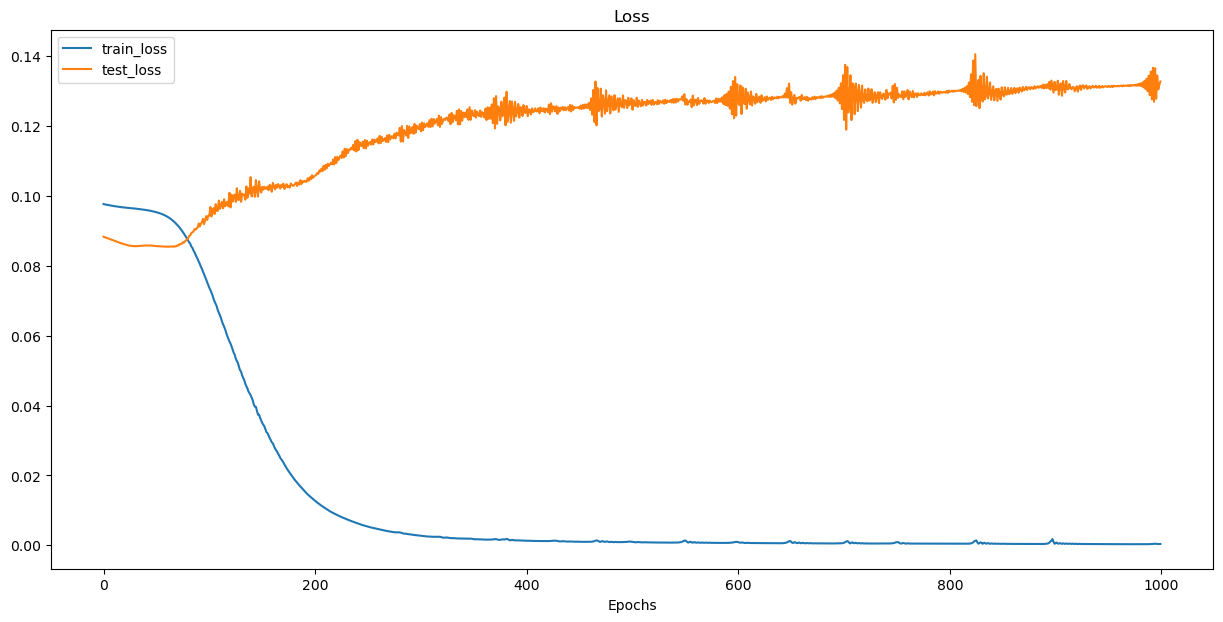

In [3029]:
utils.plot_loss_curves(model_results)

## **Evaluation**

In [3030]:
with torch.no_grad():
    training_output_weights = model(X_train)

with torch.no_grad():
    testing_output_weights = model(X_test)

In [3031]:
all_output_weights = torch.cat((training_output_weights, testing_output_weights))
all_output_weights.shape

torch.Size([763, 5])

In [3032]:
all_output_weights_df = pd.DataFrame(all_output_weights.cpu().numpy(), columns=data_model.columns[:ASSET_COUNT])
all_output_weights_df['Date'] = data_model.index[X_SEQ_LEN: None if Y_SEQ_LEN == 1 else -(Y_SEQ_LEN - 1)]
all_output_weights_df['Date'] = pd.to_datetime(all_output_weights_df['Date'])
all_output_weights_df = all_output_weights_df.set_index('Date')
all_output_weights_df

,ALE,ALR,BDX,CDR,SAVE
Date,,,,,
2021-07-02,0.981007,0.012519,0.002442,0.003789,0.000242
2021-07-05,0.981280,0.007396,0.002341,0.006365,0.002618
2021-07-06,0.531656,0.015134,0.002630,0.446949,0.003630
2021-07-07,0.248137,0.017611,0.097826,0.634722,0.001704
2021-07-08,0.014142,0.488592,0.198256,0.297557,0.001453
...,...,...,...,...,...
2024-07-09,0.210315,0.517787,0.050886,0.181463,0.039550
2024-07-10,0.158029,0.385810,0.175801,0.265746,0.014613
2024-07-11,0.140775,0.376129,0.282169,0.199041,0.001886


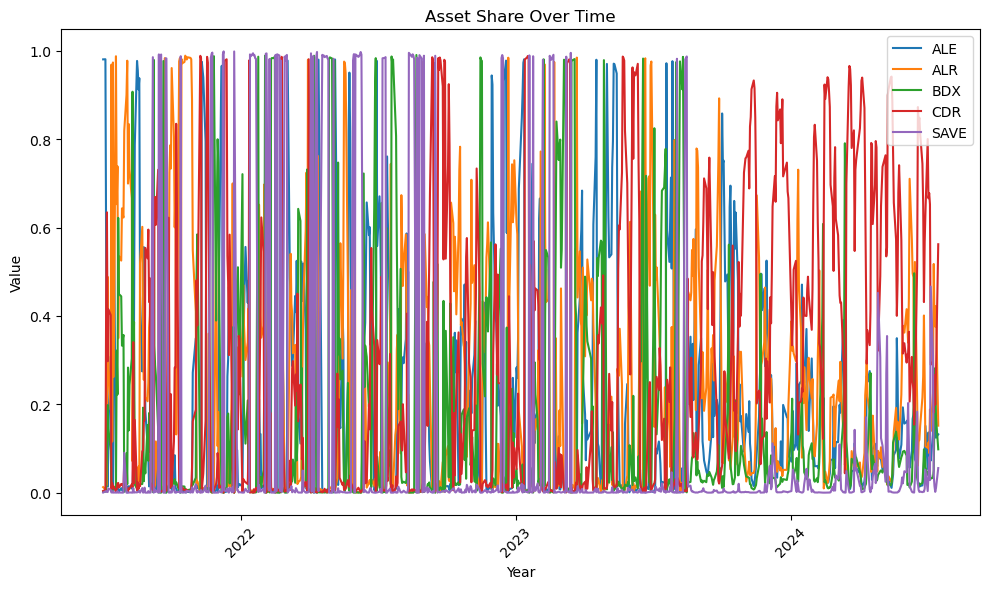

In [3033]:
utils.plot_asset_share(all_output_weights_df)

### **Profit calculation**

**Test**

In [3034]:
true_labels_daily_returns, true_labels_total_returns = utils.calculate_portfolio_return(Y_test_true_labels, 
                                                                                        Y_test[:, :, :ASSET_COUNT])

portfolio_daily_returns, portfolio_total_returns = utils.calculate_portfolio_return(testing_output_weights, 
                                                                                    Y_test[:, :, :ASSET_COUNT])

print(f'Earned profit vs true labels profit: {portfolio_total_returns:.2f}% vs {true_labels_total_returns:.2f}%')

Earned profit vs true labels profit: 0.35% vs 7.22%


**Train**

In [3035]:
true_labels_daily_returns, true_labels_total_returns = utils.calculate_portfolio_return(Y_train_true_labels, 
                                                                                        Y_train[:, :, :ASSET_COUNT])

portfolio_daily_returns, portfolio_total_returns = utils.calculate_portfolio_return(training_output_weights, 
                                                                                    Y_train[:, :, :ASSET_COUNT])

print(f'Earned profit vs true labels profit: {portfolio_total_returns:.2f}% vs {true_labels_total_returns:.2f}%')

Earned profit vs true labels profit: 178.39% vs 208.18%
